# Louisville Kentucky Fire Calls

Example project for Code Louisville Data Analysis 1 class.

## Summary

This project uses data from 
[Louisville Metro Open Data](https://data.louisvilleky.gov/) to chart the 
number of service calls by fire districts in the Louisville Metro area.

**Hypothesis:** There are fewer emergency calls in the morning (4am - 8am) than there are 
in the evening (4pm - 8pm).


## Data Discovery

Data Source: [Louisville/Jefferson County Fire Districts calls for 
service.](https://www.arcgis.com/sharing/rest/content/items/a7e8d1790a254d96998ca03e8406afa9/data)

Discovery Steps:
1. Load the service call data into a List of Dict objects
1. Print the number of records and the names of the columns
1. Print the values in the HOUR OF field

In [1]:
import csv

fire_data = []
with open('data/Fire_Open_Data.csv') as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        fire_data.append(row)


Number of records:

In [2]:
print("{:,}".format(len(fire_data)))

162,064


Columns:

In [3]:
for key in fire_data[0].keys():
    print(key)

AGENCY_NAME
DATE
CREATE
DISPATCH
ENROUTE
ARRIVE
CLEAR
HOUR OF
LOCATION
EVENT TYPE
PRIORITY
FD EVENT NUMBER
ZIP_CODE


Values in `HOUR OF` field:

In [4]:
hours = []
for record in fire_data:
    hour = record['HOUR OF']
    if hour not in hours:
        hours.append(hour)

for item in hours:
    print(item)

0000
0100
0200
0300
0400
0500
0600
0700
0800
0900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


## Data Cleaning

Cleaning Steps:
1. Define the times of day (Morning, Day, Evening, Night)
1. Create a new time of day column based on the HOUR OF field

Define times of day:

In [5]:
morning = ('0500','0600','0700','0800')
day = ('0900','1000','1100','1200','1300','1400','1500','1600','1700','1800')
evening = ('1900','2000','2100','2200')
night = ('2300','0000','0100','0200','0300','0400')

Create calculated time of day column:

In [6]:
for record in fire_data:
    hour_of = record['HOUR OF']
    if hour_of in morning:
        record['TIME_OF_DAY'] = 'morning'
    elif hour_of in day:
        record['TIME_OF_DAY'] = 'day'
    elif hour_of in evening:
        record['TIME_OF_DAY'] = 'evening'
    elif hour_of in night:
        record['TIME_OF_DAY'] = 'night'
    else:
        record['TIME_OF_DAY'] = 'other'


Values in `TIME_OF_DAY` field:

In [7]:
times = []
for record in fire_data:
    time_of_day = record['TIME_OF_DAY']
    if time_of_day not in times:
        times.append(time_of_day)

for item in times:
    print(item)

night
morning
day
evening


## Data Analysis

Which time of day has the most fire service calls?

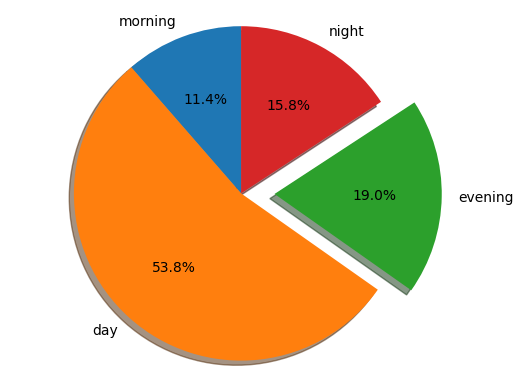

In [11]:
import matplotlib.pyplot as plt

calls_by_time_of_day = {}
for record in fire_data:
    if record['TIME_OF_DAY'] not in calls_by_time_of_day:
        calls_by_time_of_day[record['TIME_OF_DAY']] = 1
    else:
        calls_by_time_of_day[record['TIME_OF_DAY']] += 1

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'morning', 'day', 'evening', 'night'
sizes = [calls_by_time_of_day['morning'], 
        calls_by_time_of_day['day'], 
        calls_by_time_of_day['evening'], 
        calls_by_time_of_day['night']]
explode = (0, 0, 0.2, 0)  # only "explode" the 3rd slice (i.e. 'evening')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Conclusion

There are more fire services calls at night (19%) than there are in the morning (11.4%). Further analysis could be done by looking at day of week, type of call (fire, medical, etc.) or zip code.